In [1]:
import pandas as pd
import numpy as np
import re
import statistics
import nltk
from nltk.tag import pos_tag
import nltk
from nltk.corpus import stopwords
import pickle
import matplotlib.pyplot as plt
from readability import Readability

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/limjohn/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/limjohn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/limjohn/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

This is meant to find content based features. Each feature will require its own preprocessing

In [3]:
df = pd.read_csv("../data/WELFake_Dataset.csv")
df = df.dropna()
print(df.columns)
print(df.shape)
print(type(df.loc[7, "text"]))
print(df)

text_iterator = df["text"]
title_iterator = df["title"]
def combine_columns(row):
    return str(row["title"]) + ". " + str(row["text"])


# Apply the custom function to create a new column 'Combined'
df["Combined"] = df.apply(combine_columns, axis=1)
merged_iterator = df["Combined"]

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')
(71537, 4)
<class 'str'>
       Unnamed: 0                                              title  \
0               0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
2               2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3               3  Bobby Jindal, raised Hindu, uses story of Chri...   
4               4  SATAN 2: Russia unvelis an image of its terrif...   
5               5  About Time! Christian Group Sues Amazon and SP...   
...           ...                                                ...   
72129       72129  Russians steal research on Trump in hack of U....   
72130       72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131       72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132       72132  Trump tussle gives unpopular Mexican leader mu...   
72133       72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                              

Tokenise sentence length for sentence length, keep stop word

In [4]:
def process_text(text_iterator):
    text_processed = []
    empty_indexes = []
    for index,text in enumerate(text_iterator):    
        try:
            # remove some supers 
            t = re.sub("[^a-zA-Z0-9\.\?\!]", " ", text)
            # remove multiple spaces
            t = re.sub(r" +", " ", t)
            # remove newline
            t = re.sub(r"\n", " ", t)
            # clear trailing whitespaces
            t = t.strip()
            # lowercase
            t = t.lower()
            # tokenise sentences
            t = re.split("\!|\.|\?",t)
            # strip sentence
            t = [item.strip() for item in t]
            # drop empty string 
            t = list(filter(lambda x: x != "", t))
            # tokenise words 
            sentences_tokenised = []
            for sentence in t: 
                #tokenise
                s = sentence.split(" ")
                sentences_tokenised.append(s)                                
            if len(sentences_tokenised) == 0:
                print(text)
                empty_indexes.append(index)
                text_processed.append(None)
            else:
                text_processed.append(sentences_tokenised)
        except Exception as e:
            print(e)
            text_processed.append(None)
            continue
        
    return text_processed

print(process_text(["this is a test. um oops! not really? haha haha!","thats the rub. whats a rub?? ruba# dub dub!"]))


[[['this', 'is', 'a', 'test'], ['um', 'oops'], ['not', 'really'], ['haha', 'haha']], [['thats', 'the', 'rub'], ['whats', 'a', 'rub'], ['ruba', 'dub', 'dub']]]


In [5]:
merged_processed = process_text(merged_iterator)
print(len(merged_processed))
print(merged_iterator[0])
print(merged_processed[0])
print(df["label"][0])

Чем закончатся изменения региональной динамики на Ближнем Востоке | Новое восточное обозрение. Как отмечает в своей новой статье ветеран боевых действий США Гордон Даф, сегодня в «большой региональной игре» стороны меняют свою приверженность настолько же быстро, насколько заключают новые союзы. Так, Турция и Саудовская Аравия планируют усилить поддержку ДАИШ, пока Вашингтон занимает неопределенную позицию по этому вопросу. Тель-Авив, со своей стороны, посылает недвусмысленные сигналы о том, что все контакты с Белым домом «отныне нужно держать через него», на что уже, судя по всему, отреагировал Иран, который помнит обещания Трампа об отмене договора по иранской ядерной программе. После того, как боевики ХАМАС начали переправляться ЦРУ в лагеря подготовки ДАИШ, практически ни одна из региональных держав публично не возражает против дальнейшей оккупации Израилем палестинских территорий. В условиях, когда роль США сокращается в регионе, а Анкара и Тель-Авив значительно усиливают свои пози

In [6]:
# Count words per sentence, long short sentence
def sentence_count(row, limit):
    lengths = []
    short_sentence = 0
    long_sentence = 0
    sentences = len(row)
    for sentence in row:
        length = len(sentence)
        lengths.append(length)
        if length <= limit:
            short_sentence += 1
        else:
            long_sentence += 1
    if len(lengths) > 1:
        return (
            statistics.median(lengths),
            statistics.variance(lengths),
            short_sentence,
            long_sentence,
            sentences,
        )
    else:
        return lengths[0], 0, short_sentence, long_sentence, sentences


# Short/Long Sentences
limit = 10


words_per_sentence_median_ls = []
words_per_sentence_variance_ls = []
short_sentence_ls = []
long_sentence_ls = []
sentences_len_ls = [] 
for i in merged_processed:
    try:
        (
            median_sentence_length,
            var_sentence_length,
            short_sentences,
            long_sentences,
            sentences,
        ) = sentence_count(i, limit)
        words_per_sentence_median_ls.append(median_sentence_length)
        words_per_sentence_variance_ls.append(var_sentence_length)
        short_sentence_ls.append(short_sentences)
        long_sentence_ls.append(long_sentences)
        sentences_len_ls.append(sentences)
    except:
        words_per_sentence_median_ls.append(0)
        words_per_sentence_variance_ls.append(0)
        short_sentence_ls.append(0)
        long_sentence_ls.append(0)
        sentences_len_ls.append(0)
        continue



In [7]:
print(len(words_per_sentence_median_ls))
print(len(words_per_sentence_variance_ls))
print(len(long_sentence_ls))
print(len(short_sentence_ls))
print(len(sentences_len_ls))

71537
71537
71537
71537
71537


Generate parts of speech - drop stop words. 


In [8]:
# tokenise per document
def process_text(text_iterator):
    text_processed = []
    for text in text_iterator:        
        try:
            # remove punctuation
            t = re.sub("[^a-zA-Z0-9]", " ", text)
            # remove multiple spaces
            t = re.sub(r" +", " ", t)
            # remove newline
            t = re.sub(r"\n", " ", t)
            # clear trailing whitespaces
            t = t.strip()
            # lowercase
            t = t.lower()
            # tokenise
            t = t.split(" ")
            # drop empty string
            t = list(filter(lambda x: x != "", t))
            if len(t) == 0:
                text_processed.append(None)
            else:
                text_processed.append(t)
        except:
            text_processed.append(None)
            continue
    return text_processed

text_processed = process_text(merged_iterator)

print(len(text_processed))
print(text_processed[2])

stop_words = set(stopwords.words("english"))

def remove_stop_words_inner(text, stop_words):
    no_stop_words = []
    if text is None:
        return None
    for token in text:
        if token not in stop_words:
            no_stop_words.append(token)
    return no_stop_words

def remove_stop_words_outer(text_list, stop_words):
    for index, text in enumerate(text_list):
        t = remove_stop_words_inner(text, stop_words)
        text_list[index] = t
    return text_list

meged_no_stop_words = remove_stop_words_outer(text_processed, stop_words)
print(meged_no_stop_words[2])
print(len(meged_no_stop_words))


71537
['bobby', 'jindal', 'raised', 'hindu', 'uses', 'story', 'of', 'christian', 'conversion', 'to', 'woo', 'evangelicals', 'for', 'potential', '2016', 'bid', 'a', 'dozen', 'politically', 'active', 'pastors', 'came', 'here', 'for', 'a', 'private', 'dinner', 'friday', 'night', 'to', 'hear', 'a', 'conversion', 'story', 'unique', 'in', 'the', 'context', 'of', 'presidential', 'politics', 'how', 'louisiana', 'gov', 'bobby', 'jindal', 'traveled', 'from', 'hinduism', 'to', 'protestant', 'christianity', 'and', 'ultimately', 'became', 'what', 'he', 'calls', 'an', 'evangelical', 'catholic', 'over', 'two', 'hours', 'jindal', '42', 'recalled', 'talking', 'with', 'a', 'girl', 'in', 'high', 'school', 'who', 'wanted', 'to', 'save', 'my', 'soul', 'reading', 'the', 'bible', 'in', 'a', 'closet', 'so', 'his', 'parents', 'would', 'not', 'see', 'him', 'and', 'feeling', 'a', 'stir', 'while', 'watching', 'a', 'movie', 'during', 'his', 'senior', 'year', 'that', 'depicted', 'jesus', 'on', 'the', 'cross', 'i', 

Merge Title and Text

In [9]:
merged_title_text = meged_no_stop_words
print(len(merged_title_text))

71537


In [10]:
print(merged_title_text[0])

['law', 'enforcement', 'high', 'alert', 'following', 'threats', 'cops', 'whites', '9', '11by', 'blacklivesmatter', 'fyf911', 'terrorists', 'video', 'comment', 'expected', 'barack', 'obama', 'members', 'fyf911', 'fukyoflag', 'blacklivesmatter', 'movements', 'called', 'lynching', 'hanging', 'white', 'people', 'cops', 'encouraged', 'others', 'radio', 'show', 'tuesday', 'night', 'turn', 'tide', 'kill', 'white', 'people', 'cops', 'send', 'message', 'killing', 'black', 'people', 'america', 'one', 'f', 'yoflag', 'organizers', 'called', 'sunshine', 'radio', 'blog', 'show', 'hosted', 'texas', 'called', 'sunshine', 'f', 'ing', 'opinion', 'radio', 'show', 'snapshot', 'fyf911', 'lolatwhitefear', 'twitter', 'page', '9', '53', 'p', 'shows', 'urging', 'supporters', 'call', 'fyf911', 'tonight', 'continue', 'dismantle', 'illusion', 'white', 'snapshot', 'twitter', 'radio', 'call', 'invite', 'fyf911the', 'radio', 'show', 'aired', '10', '00', 'p', 'eastern', 'standard', 'time', 'show', 'callers', 'clearly

In [11]:
# parts of speech per document
pos_merged =[]
for doc in merged_title_text:
    try: 
        pos_merged.append(pos_tag(doc))
    except:
        pos_merged.append([])
print(len(pos_merged))

71537


In [12]:
print(pos_merged[0])
print(len(pos_merged[0]))
print(len(pos_merged))

[('law', 'NN'), ('enforcement', 'NN'), ('high', 'JJ'), ('alert', 'NN'), ('following', 'VBG'), ('threats', 'NNS'), ('cops', 'VBP'), ('whites', 'VBZ'), ('9', 'CD'), ('11by', 'CD'), ('blacklivesmatter', 'NN'), ('fyf911', 'NN'), ('terrorists', 'NNS'), ('video', 'VBP'), ('comment', 'NN'), ('expected', 'VBN'), ('barack', 'RB'), ('obama', 'JJ'), ('members', 'NNS'), ('fyf911', 'VBP'), ('fukyoflag', 'JJ'), ('blacklivesmatter', 'NN'), ('movements', 'NNS'), ('called', 'VBD'), ('lynching', 'VBG'), ('hanging', 'VBG'), ('white', 'JJ'), ('people', 'NNS'), ('cops', 'NNS'), ('encouraged', 'VBD'), ('others', 'NNS'), ('radio', 'VB'), ('show', 'NN'), ('tuesday', 'JJ'), ('night', 'NN'), ('turn', 'VB'), ('tide', 'JJ'), ('kill', 'NNP'), ('white', 'JJ'), ('people', 'NNS'), ('cops', 'NNS'), ('send', 'VBP'), ('message', 'NN'), ('killing', 'VBG'), ('black', 'JJ'), ('people', 'NNS'), ('america', 'VBP'), ('one', 'CD'), ('f', 'NN'), ('yoflag', 'NN'), ('organizers', 'NNS'), ('called', 'VBD'), ('sunshine', 'NN'), ('r

In [13]:
adverbs = ["RB", "RBR", "RBS", "WRB"]
nouns = ["NN", "NNS"]
proper_nouns = ["NNP", "NNPS"]
adjective = ["JJ", "JJR", "JJS"]
conjunctions = ["CC"]
verbs_third_person = ["VB", "VBD", "VBG", "VBN"]
verbs_others = ["VBP", "VBZ"]


def count_word_pos(doc, word_type):
    count = 0
    for word in doc:
        if word[1] in word_type:
            count += 1
    return count


adverb_raw_count = [count_word_pos(doc, adverbs) for doc in pos_merged]
nouns_raw_count = [count_word_pos(doc, nouns) for doc in pos_merged]
proper_nouns_raw_count = [count_word_pos(doc, proper_nouns) for doc in pos_merged]
adjective_raw_count = [count_word_pos(doc, adjective) for doc in pos_merged]
conjunction_raw_count = [count_word_pos(doc, conjunctions) for doc in pos_merged]
verbs_third_person_count = [count_word_pos(doc, verbs_third_person) for doc in pos_merged]
verbs_others_count = [count_word_pos(doc, verbs_others) for doc in pos_merged]
print(len(adverb_raw_count))
print(len(nouns_raw_count))
print(len(proper_nouns_raw_count))
print(len(adjective_raw_count))
print(len(conjunction_raw_count))
print(len(verbs_third_person_count))
print(len(verbs_others_count))

71537
71537
71537
71537
71537
71537
71537


In [14]:
print(pos_merged[0])

[('law', 'NN'), ('enforcement', 'NN'), ('high', 'JJ'), ('alert', 'NN'), ('following', 'VBG'), ('threats', 'NNS'), ('cops', 'VBP'), ('whites', 'VBZ'), ('9', 'CD'), ('11by', 'CD'), ('blacklivesmatter', 'NN'), ('fyf911', 'NN'), ('terrorists', 'NNS'), ('video', 'VBP'), ('comment', 'NN'), ('expected', 'VBN'), ('barack', 'RB'), ('obama', 'JJ'), ('members', 'NNS'), ('fyf911', 'VBP'), ('fukyoflag', 'JJ'), ('blacklivesmatter', 'NN'), ('movements', 'NNS'), ('called', 'VBD'), ('lynching', 'VBG'), ('hanging', 'VBG'), ('white', 'JJ'), ('people', 'NNS'), ('cops', 'NNS'), ('encouraged', 'VBD'), ('others', 'NNS'), ('radio', 'VB'), ('show', 'NN'), ('tuesday', 'JJ'), ('night', 'NN'), ('turn', 'VB'), ('tide', 'JJ'), ('kill', 'NNP'), ('white', 'JJ'), ('people', 'NNS'), ('cops', 'NNS'), ('send', 'VBP'), ('message', 'NN'), ('killing', 'VBG'), ('black', 'JJ'), ('people', 'NNS'), ('america', 'VBP'), ('one', 'CD'), ('f', 'NN'), ('yoflag', 'NN'), ('organizers', 'NNS'), ('called', 'VBD'), ('sunshine', 'NN'), ('r

In [16]:
# save the details
# create table 
df_features = pd.DataFrame()
df_features["label"] = df["label"]
df_features['adverbs'] = adverb_raw_count
df_features['nouns'] = nouns_raw_count
df_features['proper_nouns'] = proper_nouns_raw_count
df_features['adjectives'] = adjective_raw_count
df_features["conjunctions"] = conjunction_raw_count
df_features["verbs_third_person"] = verbs_third_person_count
df_features["verbs_others"] = verbs_others_count

# Generate df containing the words per sentence vector
df_features["words_per_sentence_variance"] = words_per_sentence_variance_ls
df_features["words_per_sentence_median"] = words_per_sentence_median_ls
df_features["num_long_sentences"] = long_sentence_ls
df_features["num_short_sentences"] = short_sentence_ls
df_features["num_of_sentences"] = sentences_len_ls

# rate of word types per sentence
df_features["adverbs_rate"] = np.where(df_features["num_of_sentences"] == 0, 0, df_features["adverbs"] / df_features["num_of_sentences"])
df_features["nouns_rate"] = np.where(df_features["num_of_sentences"] == 0, 0, df_features["nouns"] / df_features["num_of_sentences"])
df_features["proper_nouns_rate"] = np.where(df_features["num_of_sentences"] == 0, 0, df_features["proper_nouns"] / df_features["num_of_sentences"])
df_features["adjectives_rate"] = np.where(df_features["num_of_sentences"] == 0, 0, df_features["adjectives"] / df_features["num_of_sentences"])
df_features["conjunctions_rate"] = np.where(df_features["num_of_sentences"] == 0, 0, df_features["conjunctions"] / df_features["num_of_sentences"])
df_features["verbs_third_person_rate"] = np.where(df_features["num_of_sentences"] == 0, 0, df_features["verbs_third_person"] / df_features["num_of_sentences"])
df_features["verbs_others_rate"] = np.where(df_features["num_of_sentences"] == 0, 0, df_features["verbs_others"] / df_features["num_of_sentences"])

print(df_features.shape)
print(df_features.columns)
df_features.to_pickle("../data/df_content_features_part_1.pkl")

(71537, 20)
Index(['label', 'adverbs', 'nouns', 'proper_nouns', 'adjectives',
       'conjunctions', 'verbs_third_person', 'verbs_others',
       'words_per_sentence_variance', 'words_per_sentence_median',
       'num_long_sentences', 'num_short_sentences', 'num_of_sentences',
       'adverbs_rate', 'nouns_rate', 'proper_nouns_rate', 'adjectives_rate',
       'conjunctions_rate', 'verbs_third_person_rate', 'verbs_others_rate'],
      dtype='object')


In [18]:
import pandas as pd
import numpy as np
import re
import pickle
import matplotlib.pyplot as plt
from readability import Readability

### Generate readability indexes
Text must be min 100 words tho.

#### Flesch-Kincaid Grade Level
This is US Army assessment for difficulty of technical manuals. Its aim is to score the reading difficulty to ninth grade level for legal documents and financial forms. 

#### Flesch Reading Ease
This is is a standard test of readability for its documents and forms. 

#### Dale Chall Readability 
It uses readability based on familiarity of words rather than syllable or letter counts. 

#### Automated Readability Index 
relies on a factor of characters per word instead of syllables.

#### Gunning Fog
Readability for english. estimates the years of formal education needed to understand the text on a first reading. 

#### SMOG a simple measure of gobbledygook
it is used to measure readability of health literacy materials. It uses a sample of 30 sentences from the original texts but can be used to generalise the entire text as well. 

#### Spache
Is used for Primary Grade reading materials. published in 1953. Best used for difficulty of text at 3rd grade level or below. 

#### Linsear White 
Metric for English for USAF to calculate readability of technical manuals. 

Final choice: to avoid technical documents metrics, and focus on information transfer and ease of readability. should not be skewed to lower age education reading levels. 
* Dale Chall
* Gunning Fog
* SMOG
* Flesch-Kincaid 
* Automatic Readability


In [19]:
df = pd.read_csv("../data/WELFake_Dataset.csv")
df = df.dropna()
print(df.columns)
print(df.shape)
print(type(df.loc[7, "text"]))
print(df)

text_iterator = df["text"]
title_iterator = df["title"]
def combine_columns(row):
    return str(row["title"]) + ". " + str(row["text"])


# Apply the custom function to create a new column 'Combined'
df["Combined"] = df.apply(combine_columns, axis=1)
merged_iterator = df["Combined"]

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')
(71537, 4)
<class 'str'>
       Unnamed: 0                                              title  \
0               0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
2               2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3               3  Bobby Jindal, raised Hindu, uses story of Chri...   
4               4  SATAN 2: Russia unvelis an image of its terrif...   
5               5  About Time! Christian Group Sues Amazon and SP...   
...           ...                                                ...   
72129       72129  Russians steal research on Trump in hack of U....   
72130       72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131       72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132       72132  Trump tussle gives unpopular Mexican leader mu...   
72133       72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                              

In [20]:
# readability indexe preprocssing 
def process_text(text_iterator):
    text_processed = []
    for text in text_iterator:        
        try:
            # remove non ascii (language english only)
            t = re.sub(r'[^\x00-\x7F]', ' ', text)
            # remove multiple spaces
            t = re.sub(r" +", " ", t)
            # remove newline
            t = re.sub(r"\n", " ", t)
            # clear trailing whitespaces
            t = t.strip()
            # lowercase
            t = t.lower()
            if len(t) == 0:
                text_processed.append(None)
            else:
                text_processed.append(t)
        except:
            text_processed.append(None)
            continue
    return text_processed

merged_title_text = process_text(merged_iterator)

In [21]:
print(merged_title_text[1])

unbelievable! obama s attorney general says most charlotte rioters were peaceful protesters in her home state of north carolina [video]. now, most of the demonstrators gathered last night were exercising their constitutional and protected right to peaceful protest in order to raise issues and create change. loretta lynch aka eric holder in a skirt


In [22]:
readability_index_ls = []
for text in merged_title_text:
    try:
        r = Readability(text)
    except:
        r = None
    readability_index_ls.append(r)
print("done")

done


In [23]:
print(len(readability_index_ls))
print(readability_index_ls[0].dale_chall().score)
print(readability_index_ls[0].gunning_fog())
print(readability_index_ls[0].smog())
print(readability_index_ls[0].flesch_kincaid())

71537
8.7986523654749
score: 11.895350306970025, grade_level: '12'
score: 12.68835289967788, grade_level: 13
score: 8.681980408089565, grade_level: '9'


In [24]:
dale_chall_ls = []
gunning_fog_ls = []
smog_ls = []
flesch_kincaid_ls = []
automatic_readability_ls = []
r :Readability
for r in readability_index_ls:
    try:
        dale_chall_ls.append(r.dale_chall().score)
    except:    
        dale_chall_ls.append(np.NaN) 
    try:
        gunning_fog_ls.append(r.gunning_fog().score)
    except:
        gunning_fog_ls.append(np.NaN) 
    try:
        smog_ls.append(r.smog().score)
    except:    
        smog_ls.append(np.NaN)
    try:
        flesch_kincaid_ls.append(r.flesch_kincaid().score)
    except:
        flesch_kincaid_ls.append(np.NaN)
    try:
        automatic_readability_ls.append(r.ari().score)
    except:
        automatic_readability_ls.append(np.NaN)

In [25]:
print(len(dale_chall_ls))

71537


In [26]:
# import the content table 
with open("../data/df_content_features_part_1.pkl","rb") as f:
    df_features = pickle.load(f)

print(df_features.shape)
# add the readability indexes 
df_features["dale_chall"] = dale_chall_ls
df_features["gunning_fog"] = gunning_fog_ls
df_features["smog"] = smog_ls
df_features["flesch_kincaid"] = flesch_kincaid_ls
df_features["automated_readability"] = automatic_readability_ls


(71537, 20)


In [27]:
print(df_features.shape)
print(df_features.columns)
df_features.to_pickle("../data/content_features_part_2.pkl")

(71537, 25)
Index(['label', 'adverbs', 'nouns', 'proper_nouns', 'adjectives',
       'conjunctions', 'verbs_third_person', 'verbs_others',
       'words_per_sentence_variance', 'words_per_sentence_median',
       'num_long_sentences', 'num_short_sentences', 'num_of_sentences',
       'adverbs_rate', 'nouns_rate', 'proper_nouns_rate', 'adjectives_rate',
       'conjunctions_rate', 'verbs_third_person_rate', 'verbs_others_rate',
       'dale_chall', 'gunning_fog', 'smog', 'flesch_kincaid',
       'automated_readability'],
      dtype='object')


# Add special characters and capital letters count 

In [28]:
# import the content table 
with open("../data/content_features_part_2.pkl","rb") as f:
    df_features = pickle.load(f)
    
def process_text(text_iterator):
    text_processed = []
    for text in text_iterator:        
        try:
            # remove non ascii (language english only)
            t = re.sub(r'[^\x00-\x7F]', ' ', text)
            # remove multiple spaces
            t = re.sub(r" +", " ", text)
            # remove newline
            t = re.sub(r"\n", " ", t)
            # clear trailing whitespaces
            t = t.strip()
            if len(t) == 0:
                text_processed.append(None)
            else:
                text_processed.append(t)
        except:
            text_processed.append(None)
            continue
    return text_processed

merged_title_text = process_text(merged_iterator)

In [29]:
print(merged_title_text[0])

LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]. No comment is expected from Barack Obama Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to turn the tide and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called Sunshine. She has a radio blog show hosted from Texas called, Sunshine s F***ing Opinion Radio Show. A snapshot of her #FYF911 @LOLatWhiteFear Twitter page at 9:53 p.m. shows that she was urging supporters to Call now!! #fyf911 tonight we continue to dismantle the illusion of white Below is a SNAPSHOT Twitter Radio Call Invite #FYF911The radio show aired at 10:00 p.m. eastern standard time.During the show, callers clearly call for lynching and killing of white people.A 2:39 minute cli

In [30]:
capital_letters_count = []
special_characters_count = []
for text in merged_title_text:
    capital_letters_count.append(len(re.findall(r'[A-Z]', text)))
    special_characters_count.append(len(re.findall(r'[^A-Za-z0-9]', text)))

print(capital_letters_count)
print(special_characters_count)
df_features["special_char"] = special_characters_count
df_features["cap_char"] = capital_letters_count
df_features["cap_char_rate"] = np.where(df_features["num_of_sentences"] == 0, 0, df_features["cap_char"] / df_features["num_of_sentences"])
df_features["special_char_rate"] = np.where(df_features["num_of_sentences"] == 0, 0, df_features["special_char"] / df_features["num_of_sentences"])

[207, 96, 250, 139, 110, 96, 22, 84, 134, 278, 90, 99, 31, 154, 66, 130, 30, 232, 75, 56, 121, 100, 674, 112, 54, 132, 197, 199, 134, 16, 250, 81, 139, 208, 91, 57, 87, 143, 89, 246, 151, 224, 93, 72, 493, 83, 166, 259, 124, 170, 224, 234, 107, 143, 89, 226, 56, 82, 97, 94, 307, 114, 121, 53, 112, 130, 225, 38, 153, 160, 79, 30, 96, 129, 39, 447, 30, 10, 70, 369, 69, 166, 98, 155, 228, 105, 162, 190, 50, 209, 73, 40, 132, 93, 66, 97, 75, 236, 12, 273, 224, 70, 232, 115, 28, 134, 37, 174, 122, 146, 89, 74, 1241, 124, 118, 88, 228, 65, 105, 578, 642, 175, 149, 403, 162, 208, 35, 77, 167, 178, 101, 71, 69, 122, 109, 42, 128, 56, 132, 177, 92, 78, 326, 290, 140, 181, 83, 176, 240, 48, 116, 1274, 47, 167, 121, 87, 96, 112, 136, 206, 66, 143, 211, 67, 174, 233, 314, 108, 71, 89, 172, 92, 124, 126, 112, 133, 87, 70, 210, 30, 66, 242, 95, 435, 1193, 154, 135, 96, 251, 88, 195, 204, 32, 139, 54, 59, 28, 244, 31, 11, 98, 57, 74, 319, 409, 74, 129, 56, 37, 77, 163, 94, 40, 44, 62, 91, 160, 17, 84

In [31]:
print(df_features.shape)
print(df_features.columns)
df_features.to_pickle("../data/content_features_part_3.pkl")

(71537, 29)
Index(['label', 'adverbs', 'nouns', 'proper_nouns', 'adjectives',
       'conjunctions', 'verbs_third_person', 'verbs_others',
       'words_per_sentence_variance', 'words_per_sentence_median',
       'num_long_sentences', 'num_short_sentences', 'num_of_sentences',
       'adverbs_rate', 'nouns_rate', 'proper_nouns_rate', 'adjectives_rate',
       'conjunctions_rate', 'verbs_third_person_rate', 'verbs_others_rate',
       'dale_chall', 'gunning_fog', 'smog', 'flesch_kincaid',
       'automated_readability', 'special_char', 'cap_char', 'cap_char_rate',
       'special_char_rate'],
      dtype='object')


## Select Features using linearity check

In [32]:
with open("../data/content_features_part_3.pkl","rb") as f:
    df_features = pickle.load(f)
print(df_features.columns)
df_features.head()

Index(['label', 'adverbs', 'nouns', 'proper_nouns', 'adjectives',
       'conjunctions', 'verbs_third_person', 'verbs_others',
       'words_per_sentence_variance', 'words_per_sentence_median',
       'num_long_sentences', 'num_short_sentences', 'num_of_sentences',
       'adverbs_rate', 'nouns_rate', 'proper_nouns_rate', 'adjectives_rate',
       'conjunctions_rate', 'verbs_third_person_rate', 'verbs_others_rate',
       'dale_chall', 'gunning_fog', 'smog', 'flesch_kincaid',
       'automated_readability', 'special_char', 'cap_char', 'cap_char_rate',
       'special_char_rate'],
      dtype='object')


,label,adverbs,nouns,proper_nouns,adjectives,conjunctions,verbs_third_person,verbs_others,words_per_sentence_variance,words_per_sentence_median,...,verbs_others_rate,dale_chall,gunning_fog,smog,flesch_kincaid,automated_readability,special_char,cap_char,cap_char_rate,special_char_rate
0,1,18,218,1,100,1,85,38,77.948870,13.0,...,0.633333,8.798652,11.895350,12.688353,8.681980,8.968798,1076,207,3.450000,17.933333
2,1,1,19,0,8,0,3,4,124.333333,13.5,...,1.000000,NaN,NaN,NaN,NaN,NaN,61,96,24.000000,15.250000
3,0,28,377,1,149,0,137,35,213.760973,19.0,...,0.564516,9.609612,16.245782,15.514039,12.683997,13.495336,1578,250,4.032258,25.451613
4,1,5,102,0,46,0,27,4,341.935897,25.0,...,0.307692,12.289804,19.805272,NaN,16.267989,17.923524,400,139,10.692308,30.769231
5,1,5,83,0,34,0,16,13,149.266667,14.0,...,0.866667,10.485521,18.692093,NaN,13.743457,15.275581,299,110,7.333333,19.933333


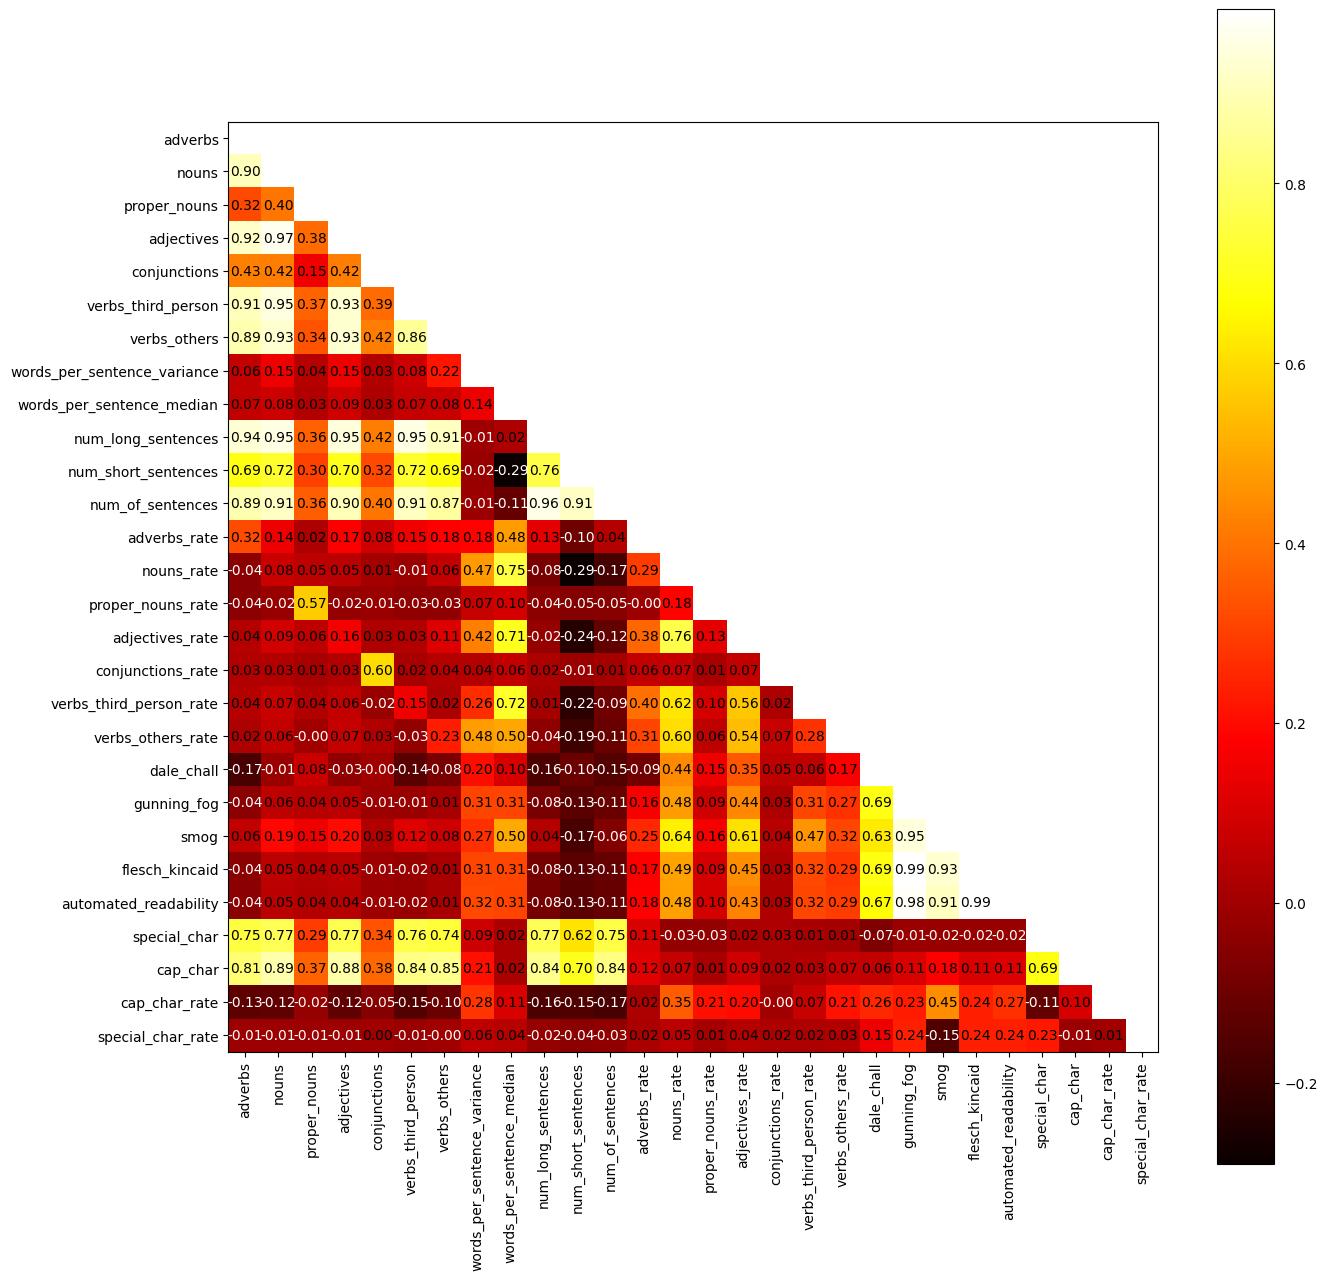

In [33]:
# linearity check
cols = list(df_features.columns)
cols.remove("label")
df_linearity = pd.DataFrame(index=cols, columns=cols,dtype=float)
for i, col in enumerate(cols):
    for other in cols[:i]:
        correlation = df_features[col].corr(df_features[other])
        # print(f"Correlation between {col} and {other}:", correlation)
        df_linearity.loc[col,other] = correlation

plt.figure(figsize=(15,15))
plt.imshow(df_linearity, cmap='hot', interpolation='nearest')
plt.xticks(ticks=range(len(cols)), labels=cols, rotation=90)
plt.yticks(ticks=range(len(cols)), labels=cols)
# Annotate the heatmap with numbers
for y in range(len(cols)):
    for x in range(len(cols)):
        plt.text(x, y, f'{df_linearity.iloc[y, x]:.2f}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='black' if df_linearity.iloc[y, x] > 0 else 'white')
plt.colorbar() 
plt.show()

In [34]:
# selecting columns 
cols_to_drop = {}
for i,col in enumerate(cols):
    for other in cols[:i]:
        if df_linearity.loc[col,other] >= 0.95:
            if col not in cols_to_drop.keys(): 
                cols_to_drop[col] = []
            cols_to_drop[col].append(other)
for i in cols_to_drop:
    print(i+str(cols_to_drop[i]))

adjectives['nouns']
num_long_sentences['nouns', 'verbs_third_person']
num_of_sentences['num_long_sentences']
flesch_kincaid['gunning_fog']
automated_readability['gunning_fog', 'flesch_kincaid']


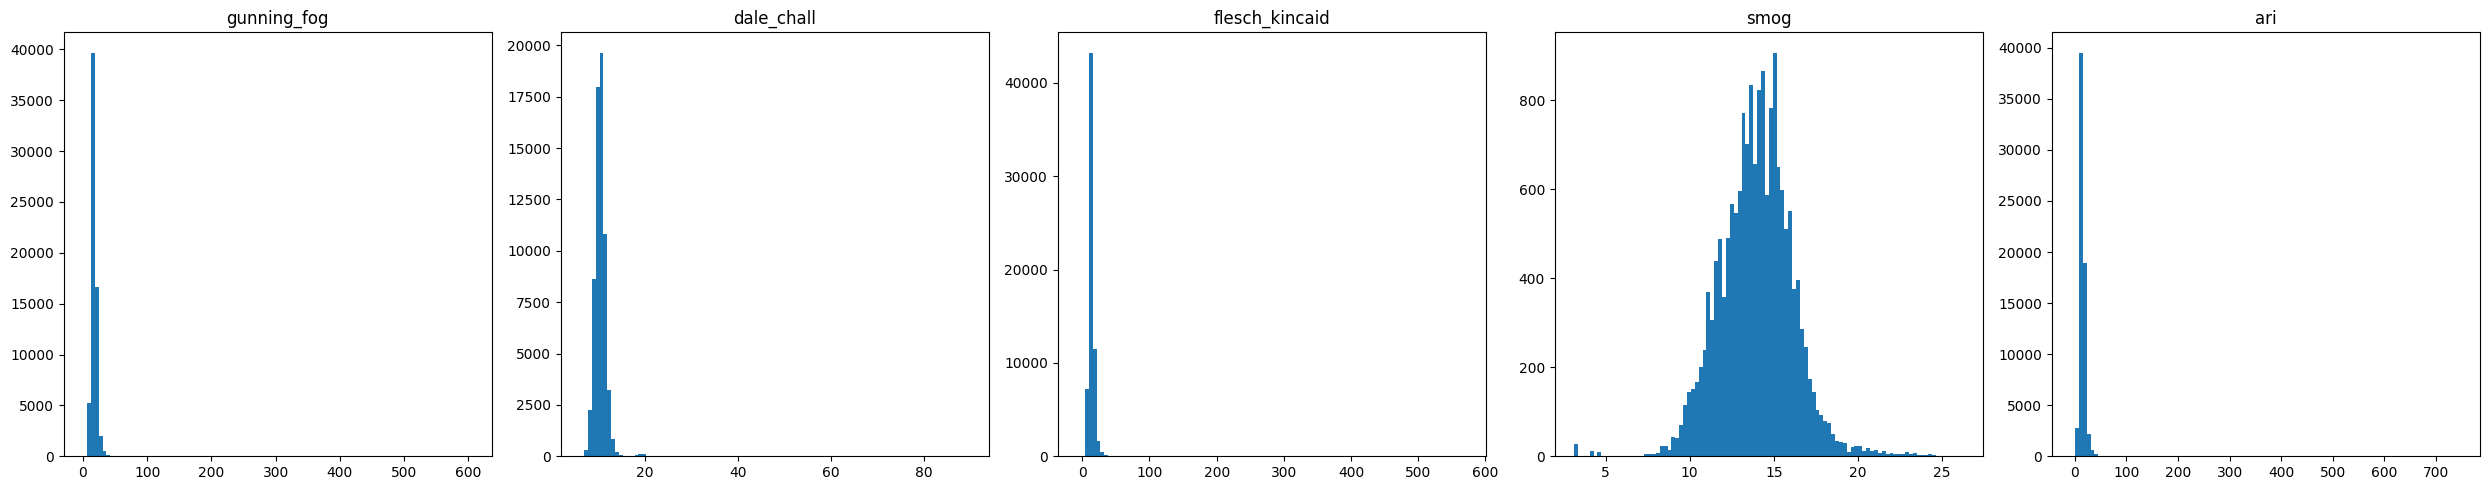

In [35]:
# check the distribution of the readability indexes 

fig, axs = plt.subplots(1,5, figsize=(25, 5))

axs[0].hist(df_features["gunning_fog"], bins=100)
axs[0].set_title("gunning_fog")
axs[1].hist(df_features["dale_chall"], bins=100)
axs[1].set_title("dale_chall")
axs[2].hist(df_features["flesch_kincaid"], bins=100)
axs[2].set_title("flesch_kincaid")
axs[3].hist(df_features["smog"], bins=100)
axs[3].set_title("smog")
axs[4].hist(df_features["automated_readability"], bins=100)
axs[4].set_title("ari")

# Adjusting the layout to ensure that the subplots do not overlap
plt.tight_layout()

# Displaying the figure with all subplots
plt.show()

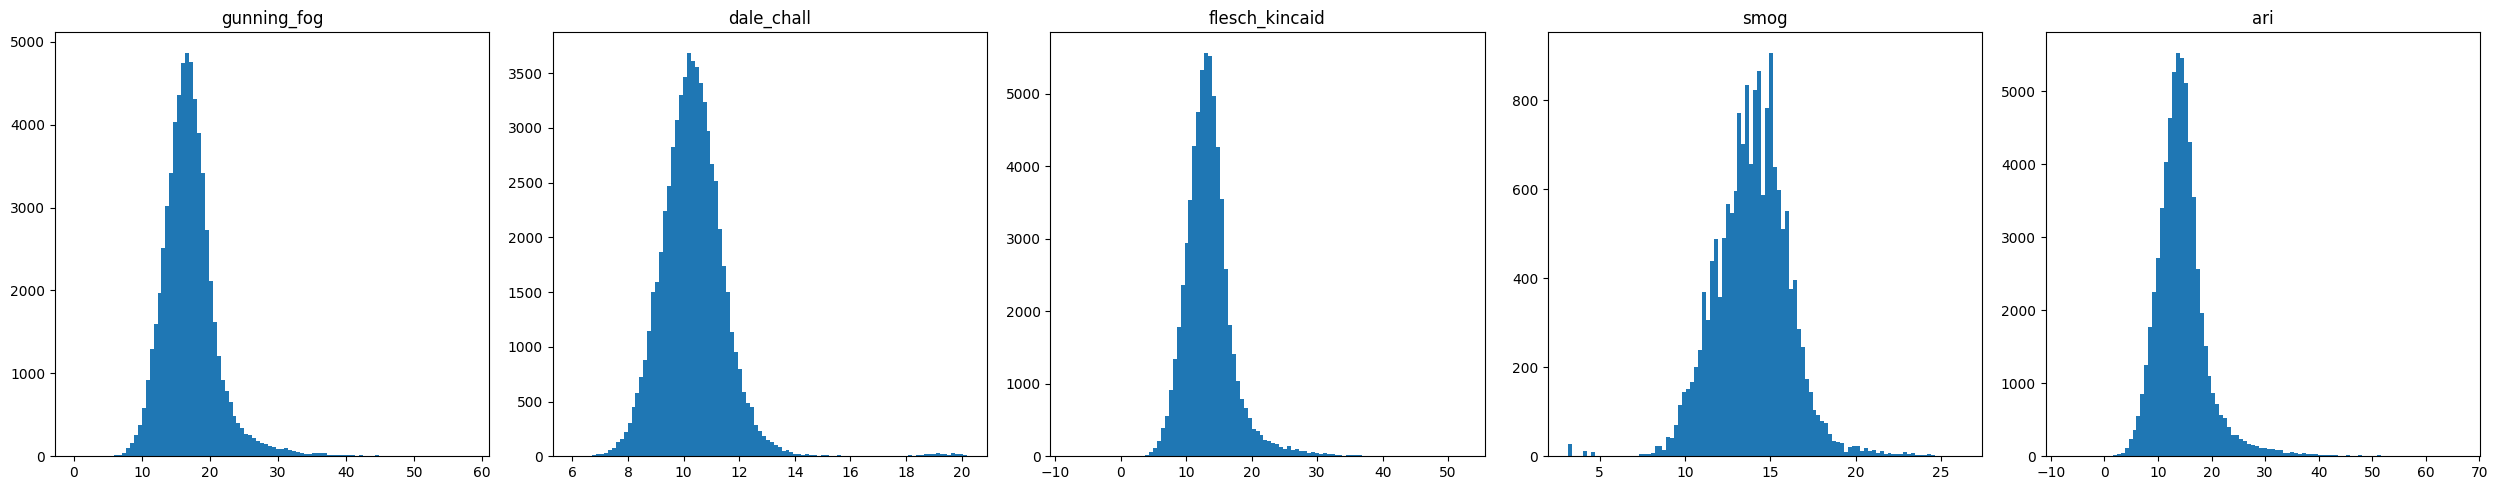

In [36]:
# drop the edge cases so we can observe the distribution better
quantile = 0.999
gunning_fog_percentile = df_features["gunning_fog"].quantile(quantile)
dale_chall_percentile = df_features["dale_chall"].quantile(quantile)
flesch_kincaid_percentile = df_features["flesch_kincaid"].quantile(quantile)
ari_percentile = df_features["automated_readability"].quantile(quantile)

# check the distribution of the readability indexes 
fig, axs = plt.subplots(1,5, figsize=(25, 5))

axs[0].hist(df_features[df_features["gunning_fog"]<gunning_fog_percentile]["gunning_fog"], bins=100)
axs[0].set_title("gunning_fog")
axs[1].hist(df_features[df_features["dale_chall"]<dale_chall_percentile]["dale_chall"], bins=100)
axs[1].set_title("dale_chall")
axs[2].hist(df_features[df_features["flesch_kincaid"]<flesch_kincaid_percentile]["flesch_kincaid"], bins=100)
axs[2].set_title("flesch_kincaid")
axs[3].hist(df_features["smog"], bins=100)
axs[3].set_title("smog")
axs[4].hist(df_features[df_features["automated_readability"]<ari_percentile]["automated_readability"], bins=100)
axs[4].set_title("ari")

# Adjusting the layout to ensure that the subplots do not overlap
plt.tight_layout()

# Displaying the figure with all subplots
plt.show()

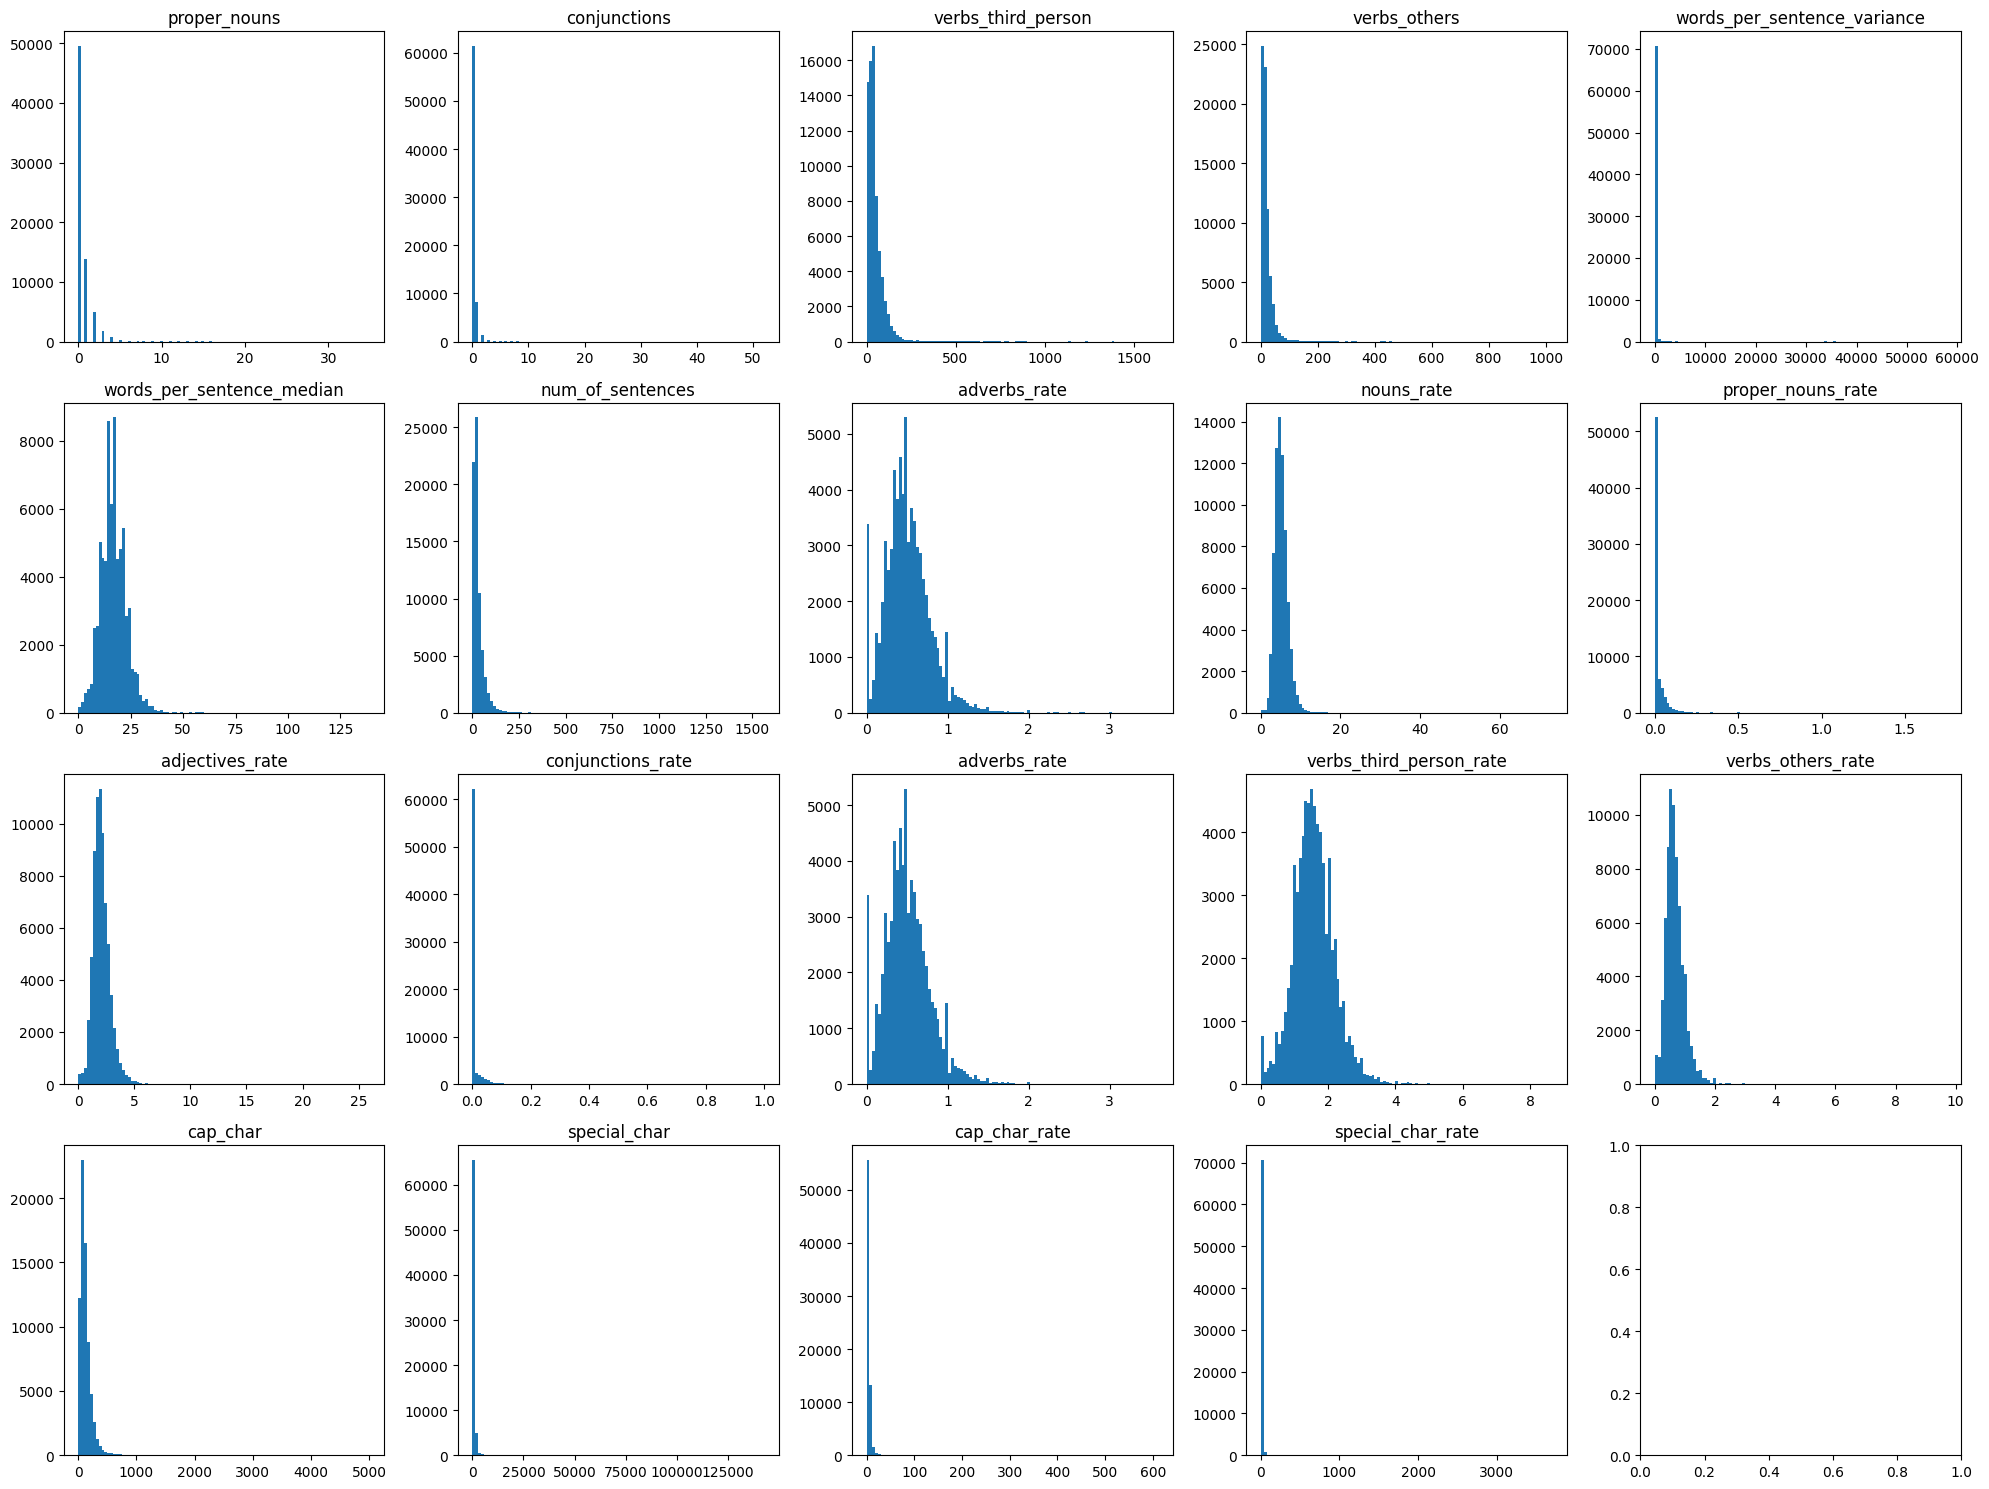

In [37]:
# check the distribution of the different variables

fig, axs = plt.subplots(4,5, figsize=(20,15))
bins = 100

axs[0,0].hist(df_features["proper_nouns"], bins=bins)
axs[0,0].set_title("proper_nouns")
axs[0,1].hist(df_features["conjunctions"], bins=bins)
axs[0,1].set_title("conjunctions")
axs[0,2].hist(df_features["verbs_third_person"], bins=bins)
axs[0,2].set_title("verbs_third_person")
axs[0,3].hist(df_features["verbs_others"], bins=bins)
axs[0,3].set_title("verbs_others")
axs[0,4].hist(df_features["words_per_sentence_variance"], bins=bins)
axs[0,4].set_title("words_per_sentence_variance")
axs[1,0].hist(df_features["words_per_sentence_median"], bins=bins)
axs[1,0].set_title("words_per_sentence_median")
axs[1,1].hist(df_features["num_of_sentences"], bins=bins)
axs[1,1].set_title("num_of_sentences")
axs[1,2].hist(df_features["adverbs_rate"], bins=bins)
axs[1,2].set_title("adverbs_rate")
axs[1,3].hist(df_features["nouns_rate"], bins=bins)
axs[1,3].set_title("nouns_rate")
axs[1,4].hist(df_features["proper_nouns_rate"], bins=bins)
axs[1,4].set_title("proper_nouns_rate")
axs[2,0].hist(df_features["adjectives_rate"], bins=bins)
axs[2,0].set_title("adjectives_rate")
axs[2,1].hist(df_features["conjunctions_rate"], bins=bins)
axs[2,1].set_title("conjunctions_rate")
axs[2,2].hist(df_features["adverbs_rate"], bins=bins)
axs[2,2].set_title("adverbs_rate")
axs[2,3].hist(df_features["verbs_third_person_rate"], bins=bins)
axs[2,3].set_title("verbs_third_person_rate")
axs[2,4].hist(df_features["verbs_others_rate"], bins=bins)
axs[2,4].set_title("verbs_others_rate")
axs[3,0].hist(df_features["cap_char"], bins=bins)
axs[3,0].set_title("cap_char")
axs[3,1].hist(df_features["special_char"], bins=bins)
axs[3,1].set_title("special_char")
axs[3,2].hist(df_features["cap_char_rate"], bins=bins)
axs[3,2].set_title("cap_char_rate")
axs[3,3].hist(df_features["special_char_rate"], bins=bins)
axs[3,3].set_title("special_char_rate")


# Adjusting the layout to ensure that the subplots do not overlap
plt.tight_layout()

# Displaying the figure with all subplots
plt.show()

# cols to drop

In [38]:
# drop features with high correlation
print(df_features.shape)
df_pos_clean = df_features.drop(
    columns=[
        "nouns",
        "adjectives",
        "adverbs",
        "num_long_sentences",
        "num_short_sentences",
        "gunning_fog",
        "flesch_kincaid",
        "dale_chall",
        "smog",
        "automated_readability"
    ]
)
print(df_pos_clean.shape)
print(list(df_pos_clean.columns))

# all content features without readability indexes
df_pos_all_features = df_features.drop(
    columns=[
        "gunning_fog",
        "flesch_kincaid",
        "dale_chall",
        "smog",
        "automated_readability"
    ]
)
print(df_pos_all_features.shape)
print(list(df_pos_all_features.columns))


(71537, 29)
(71537, 19)
['label', 'proper_nouns', 'conjunctions', 'verbs_third_person', 'verbs_others', 'words_per_sentence_variance', 'words_per_sentence_median', 'num_of_sentences', 'adverbs_rate', 'nouns_rate', 'proper_nouns_rate', 'adjectives_rate', 'conjunctions_rate', 'verbs_third_person_rate', 'verbs_others_rate', 'special_char', 'cap_char', 'cap_char_rate', 'special_char_rate']
(71537, 24)
['label', 'adverbs', 'nouns', 'proper_nouns', 'adjectives', 'conjunctions', 'verbs_third_person', 'verbs_others', 'words_per_sentence_variance', 'words_per_sentence_median', 'num_long_sentences', 'num_short_sentences', 'num_of_sentences', 'adverbs_rate', 'nouns_rate', 'proper_nouns_rate', 'adjectives_rate', 'conjunctions_rate', 'verbs_third_person_rate', 'verbs_others_rate', 'special_char', 'cap_char', 'cap_char_rate', 'special_char_rate']


In [40]:
columns_to_standardize = list(df_pos_all_features.columns)
columns_to_standardize.remove("label")
print(columns_to_standardize)
df_pos_all_features[columns_to_standardize] = (df_pos_all_features[columns_to_standardize] - df_pos_all_features[columns_to_standardize].mean()) / df_pos_all_features[columns_to_standardize].std()
df_pos_all_features.to_pickle("../data/content_features_cv2.pkl")
df_pos_all_features.to_csv("../data/content_features_cv2.csv")


columns_to_standardize = list(df_pos_clean.columns)
columns_to_standardize.remove("label")
df_pos_clean[columns_to_standardize] = (df_pos_clean[columns_to_standardize] - df_pos_clean[columns_to_standardize].mean()) / df_pos_clean[columns_to_standardize].std()
df_pos_clean.to_pickle("../data/content_features_cv1.pkl")
df_pos_clean.to_csv("../data/content_features_cv1.csv")

['adverbs', 'nouns', 'proper_nouns', 'adjectives', 'conjunctions', 'verbs_third_person', 'verbs_others', 'words_per_sentence_variance', 'words_per_sentence_median', 'num_long_sentences', 'num_short_sentences', 'num_of_sentences', 'adverbs_rate', 'nouns_rate', 'proper_nouns_rate', 'adjectives_rate', 'conjunctions_rate', 'verbs_third_person_rate', 'verbs_others_rate', 'special_char', 'cap_char', 'cap_char_rate', 'special_char_rate']
